In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis, shapiro, ttest_ind,mannwhitneyu, levene, linregress, pearsonr
import statsmodels.api as sm
import scikit_posthocs as sp
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm


In [13]:
# Učitavanje skupa podataka
data = pd.read_csv("babies.csv")

# Pregled prvih nekoliko redaka
data.head()

,case,bwt,gestation,parity,age,height,weight,smoke
0,1,120,284.0,0,27.0,62.0,100.0,0.0
1,2,113,282.0,0,33.0,64.0,135.0,0.0
2,3,128,279.0,0,28.0,64.0,115.0,1.0
3,4,123,NaN,0,36.0,69.0,190.0,0.0
4,5,108,282.0,0,23.0,67.0,125.0,1.0


In [14]:
# Broj nedostajućih vrijednosti po stupcima
data.isnull().sum()

case          0
bwt           0
gestation    13
parity        0
age           2
height       22
weight       36
smoke        10
dtype: int64

In [15]:
# Uklanjanje redaka s nedostajućim vrijednostima
data = data.dropna()

# Provjera nakon čišćenja
data.isnull().sum()

case         0
bwt          0
gestation    0
parity       0
age          0
height       0
weight       0
smoke        0
dtype: int64

In [16]:
# Broj dupliciranih redaka
data.duplicated().sum()

np.int64(0)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1174 entries, 0 to 1235
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   case       1174 non-null   int64  
 1   bwt        1174 non-null   int64  
 2   gestation  1174 non-null   float64
 3   parity     1174 non-null   int64  
 4   age        1174 non-null   float64
 5   height     1174 non-null   float64
 6   weight     1174 non-null   float64
 7   smoke      1174 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 82.5 KB


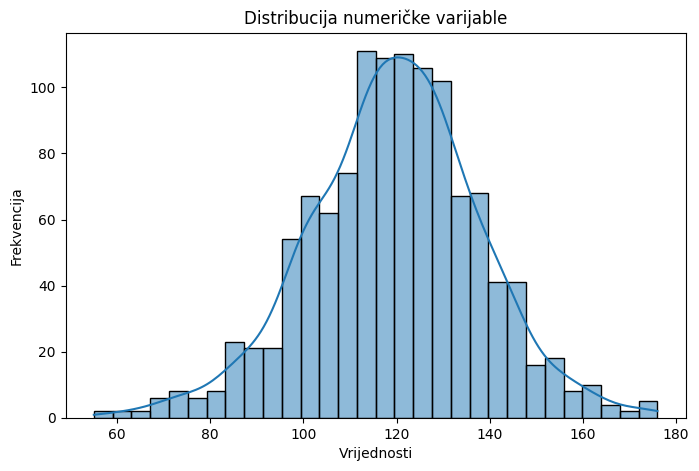

In [18]:
plt.figure(figsize=(8,5))
sns.histplot(data['bwt'], bins=30, kde=True)
plt.title('Distribucija numeričke varijable')
plt.xlabel('Vrijednosti')
plt.ylabel('Frekvencija')
plt.show()


Histogram prikazuje distribuciju zavisne numeričke varijable BWT (težina novorođenčeta). Na osi x nalaze se vrijednosti težine novorođenčadi, dok os y prikazuje frekvenciju, odnosno broj opažanja unutar pojedinih intervala težine. Distribucija ima približno zvonolik (normalan) oblik, s najvećom koncentracijom vrijednosti u srednjem području, što ukazuje da većina novorođenčadi ima težinu blisku prosječnoj vrijednosti uz postupno smanjenje frekvencije prema nižim i višim težinama.

Uočen je blagi raspon vrijednosti prema višim težinama, što može upućivati na laganu asimetriju udesno, no bez izraženih ekstremnih odstupanja. Prisutnost nekoliko opažanja na rubovima distribucije može predstavljati novorođenčad s izrazito niskom ili visokom porođajnom težinom, ali ona ne narušavaju značajno ukupni oblik distribucije.

Ovakav oblik histograma sugerira da je varijabla BWT približno normalno distribuirana, što je povoljno za daljnju primjenu metoda linearne regresije i parametarskih statističkih analiza. Distribucija ne pokazuje višestruke vrhove niti izraženu nepravilnost, što dodatno potvrđuje stabilnost i homogenost podataka o težini novorođenčadi u promatranom uzorku.

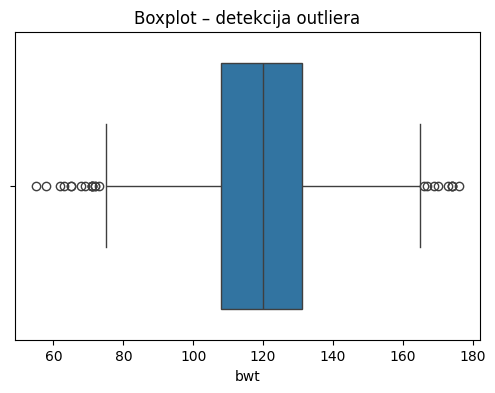

In [19]:
plt.figure(figsize=(6,4))
sns.boxplot(x=data['bwt'])
plt.title('Boxplot – detekcija outliera')
plt.show()

Boxplot prikazuje raspodjelu zavisne numeričke varijable BWT (težina novorođenčeta) te se koristi za vizualnu detekciju iznimnih vrijednosti (outliera). Središnji pravokutnik (kutija) predstavlja interkvartilni raspon (IQR), odnosno raspon između prvog (Q1) i trećeg kvartila (Q3), u kojem se nalazi srednjih 50 % podataka. Linija unutar kutije označava medijan, koji predstavlja središnju vrijednost porođajne težine.

“Brkovi” boxplota protežu se do minimalnih i maksimalnih vrijednosti koje nisu iznimne, odnosno do granica definiranih kao Q1 − 1.5·IQR i Q3 + 1.5·IQR. Vrijednosti koje se nalaze izvan tih granica prikazane su kao pojedinačne točke i predstavljaju outliere. Na grafu se može uočiti nekoliko outliera i na donjem i na gornjem dijelu distribucije, što ukazuje na prisutnost novorođenčadi s izrazito niskom ili visokom porođajnom težinom.

Većina podataka koncentrirana je unutar relativno uskog raspona oko medijana, što upućuje na umjerenu varijabilnost porođajne težine. Iako su prisutni outlieri, njihov broj nije velik te ne narušava značajno ukupnu raspodjelu podataka. Takve vrijednosti mogu imati stvarno značenje (npr. prijevremeni porod ili izuzetno velika porođajna težina) te ih je prije uklanjanja potrebno pažljivo razmotriti

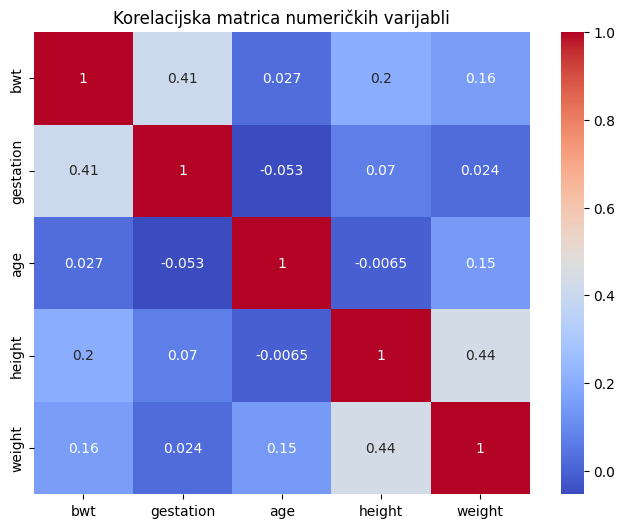

In [20]:
# Odabir samo numeričkih stupaca
numeric_data = ["bwt", "gestation", "age", "height", "weight"]
data[numeric_data]
# Korelacijska matrica
plt.figure(figsize=(8,6))
sns.heatmap(data[numeric_data].corr(), annot=True, cmap='coolwarm')
plt.title('Korelacijska matrica numeričkih varijabli')
plt.show()

Korelacijska matrica
Korelacijska matrica prikazuje jačinu i smjer linearne povezanosti između
numeričkih varijabli u skupu podataka.

U analizu su uključene isključivo numeričke varijable jer se korelacija ne može izračunati za kategorijske (tekstualne) podatke.

Vrijednosti korelacije kreću se od -1 do 1:
- vrijednosti blizu 1 označavaju jaku pozitivnu povezanost
- vrijednosti blizu -1 označavaju jaku negativnu povezanost
- vrijednosti blizu 0 ukazuju na slabu ili nepostojeću povezanost


In [21]:
data[numeric_data].describe()

,bwt,gestation,age,height,weight
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,27.228279,64.049404,128.478705
std,18.328671,16.010305,5.817839,2.526102,20.734282
min,55.000000,148.000000,15.000000,53.000000,87.000000
25%,108.000000,272.000000,23.000000,62.000000,114.250000
50%,120.000000,280.000000,26.000000,64.000000,125.000000
75%,131.000000,288.000000,31.000000,66.000000,139.000000
max,176.000000,353.000000,45.000000,72.000000,250.000000


In [22]:
skewness_bwt = skew(data['bwt'])
kurt_bwt = kurtosis(data['bwt'])
print('Skewness_price_usd:', skewness_bwt)
print('Kurtosis_price_usd:', kurt_bwt)

Skewness_price_usd: -0.13321036699785416
Kurtosis_price_usd: 0.4343593409660236


Asimetrija (skewness) opisuje simetriju distribucije podataka.
Desna asimetrija → većina podataka manja, nekoliko velikih vrijednosti odskače
Lijeva asimetrija → većina podataka veća, nekoliko malih vrijednosti odskače
Ako je distribucija desno asimetrična, prosjek > medijan. Ako je lijevo asimetrična, prosjek < medijan.

Vrijednost koeficijenta asimetrije (skewness) za varijablu price_usd iznosi −0.133, što ukazuje na blagu negativnu asimetriju distribucije. Negativna asimetrija znači da distribucija ima nešto dulji rep prema manjim vrijednostima, odnosno da su niže vrijednosti blago češće ili izraženije u odnosu na više vrijednosti.

Kurtosis mjeri koliko je raspodjela “oštra” ili “ravna” u odnosu na normalnu distribuciju.

Ako je kurt ≈ 0 → distribucija je slična normalnoj

Visoka kurtosis → distribucija je šiljata, repovi su “teški” → više ekstremnih vrijednosti/outliera
Ako je kurt > 0 → distribucija je šiljast

Niska kurtosis → distribucija je ravna / spljoštena, repovi su tanki → manje ekstremnih vrijednosti
Ako je kurt < 0 → distribucija je ravna

In [23]:
data_range = data['bwt'].max() - data['bwt'].min()
data_range


np.int64(121)

In [24]:
# Shapiro-Wilk test normalnosti
stat, p_value = shapiro(data['bwt'])
stat, p_value

(np.float64(0.9956294764609604), np.float64(0.0019165908765839351))

Shapiro-Wilk test normalnosti - statistički test normalnosti, provjerava jesu li podaci približno normalno distribuirani.

Normalna distribucija - Gaussova, simetrična (zvonasti oblik), većina vrijednostri blizu sredine, ključna predpostavka za parametarske testove.Puno statističkih metoda predpostavlja normalnost.

Hipoteza Shapira:
H0 - podaci su normalno distribuirani
H1-alternativna hipoteza, nisu normalno distribuirani.
ako je p ≥ 0.05 → NE odbacujemo H₀
ako je p < 0.05 → ODBACUJEMO H₀

stat = W statistika
W mjeri koliko su tvoji podaci bliski normalnoj distribuciji.
Što je W bliže 1 → distribucija je bliža normalnoj
Manji W → veće odstupanje od normalnosti

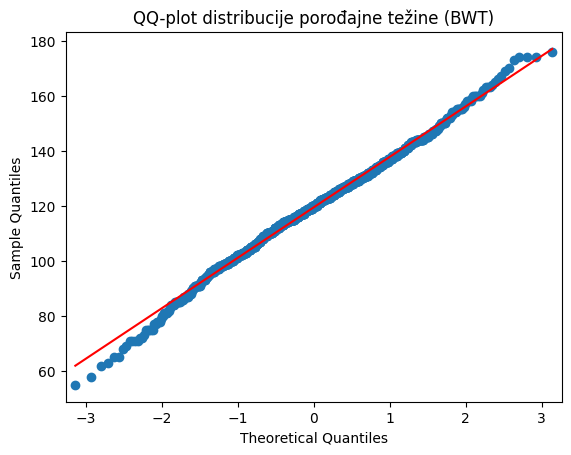

In [25]:

sm.qqplot(data['bwt'], line='s')
plt.title("QQ-plot distribucije porođajne težine (BWT)")
plt.show()

In [26]:
# Razlika po pušaćima
group_p = data[data['smoke'] == 1 ]['bwt']
group_n = data[data['smoke'] == 0 ]['bwt']

u_stat, p_value = mannwhitneyu(group_p, group_n)

print("Mann–Whitney U test")
print("-------------------")
print(f"U statistika = {u_stat:.2f}")
print(f"p-vrijednost = {p_value:.4f}")


Mann–Whitney U test
-------------------
U statistika = 115215.00
p-vrijednost = 0.0000


In [27]:

group_pa = data[data['parity'] == 1]['bwt']
group_np = data[data['parity'] == 0]['bwt']

u_stat, p_value = mannwhitneyu(group_pa, group_np)

print("Mann–Whitney U test")
print("-------------------")
print(f"U statistika = {u_stat:.2f}")
print(f"p-vrijednost = {p_value:.4f}")

Mann–Whitney U test
-------------------
U statistika = 123000.50
p-vrijednost = 0.0425


Mann–Whitney U test - neparametarski ekvivalent t-testa, koristi se kad podaci nisu normalni, uspoređuje raspodjele, ne sredine

Kod t-testa:uspoređuje se aritmetička sredina (mean) dviju skupina.pitanje je:Jesu li prosječne vrijednosti dviju skupina različite?
Kod Mann–Whitney U testa:ne koristi se sredina,koristi se rangiranje podataka, pitanje je:Jesu li vrijednosti jedne skupine općenito veće ili manje od vrijednosti druge skupine?Dakle, gleda se cijeli oblik raspodjele, a ne samo jedan broj (mean).“Jesu li vrijednosti iz jedne skupine uglavnom veće?”

H0 - nema razlike
p < 0.05 → razlika je statistički značajna
p ≥ 0.05 → nema dovoljno dokaza za razliku

veliki |t| → velika razlika u odnosu na šum

mali |t| → razlika može biti slučajna

MALI U → veća razlika između grupa
VELIKI U → manja razlika između grupa

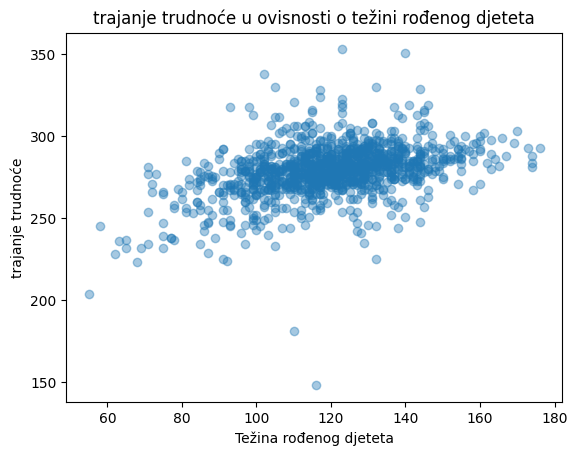

In [28]:
plt.scatter(data["bwt"], data["gestation"], alpha=0.4)
plt.xlabel("Težina rođenog djeteta")
plt.ylabel("trajanje trudnoće")
plt.title("trajanje trudnoće u ovisnosti o težini rođenog djeteta")
plt.show()

In [29]:
x = data["bwt"]
y = data["gestation"]

slope, intercept, r, p, se = linregress(x, y)

print(f"y = {intercept:.2f} + {slope:.4f}x, R^2 = {r**2:.3f}")


y = 236.57 + 0.3560x, R^2 = 0.166


Regresijska jednadžba pokazuje da s porastom dana trudnoće kod majke dolazi do porasta težine dijeteta. Nagib regresijske linije pokazuje da povećanje dana trudnoće majke za jednu jedinicu uzrokuje prosječan porast težine djeteta za približno 0.3560 jedinice. Koeficijent determinacije R² = 0.166 ukazuje da model objašnjava samo 16.6% varijabilnosti y je objašnjeno varijablom x dio varijabilnosti težine djeteta₂, dok preostali dio varijacije ovisi o drugim čimbenicima koji nisu uključeni u model.
Intercept = 236.57 - procijenjena težina djeteta kada su dani trudnoce 0 (teoretska vrijednost, služi kao početna razina modela)
y - predviđena vrijednost visine majke
x - težina djeteta

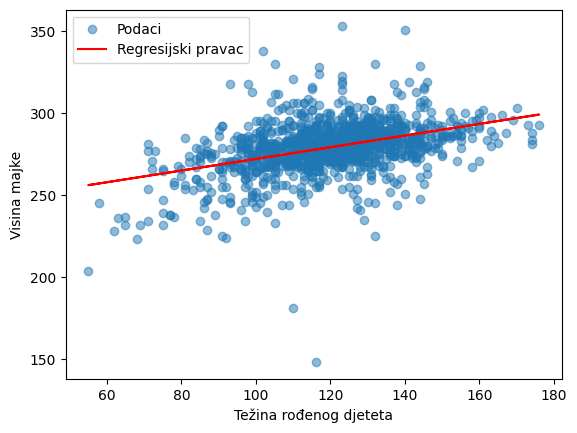

In [ ]:
plt.scatter(x, y, alpha=0.5, label="Podaci")
plt.plot(x, intercept + slope*x, color="red", label="Regresijski pravac")
plt.xlabel("Težina rođenog djeteta")
plt.ylabel("dani trudnoće")
plt.legend()
plt.show()

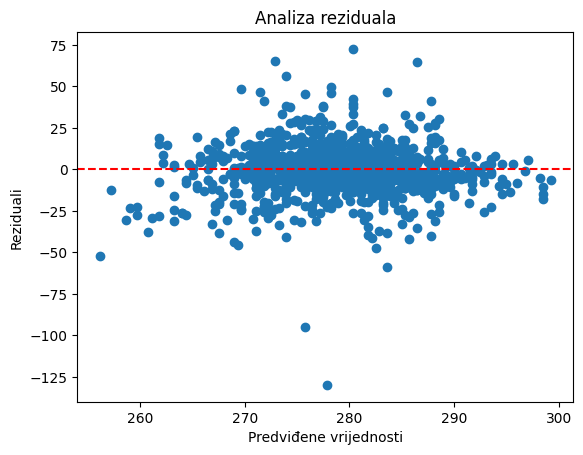

In [31]:
y_pred = intercept + slope*x
residuals = y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predviđene vrijednosti")
plt.ylabel("Reziduali")
plt.title("Analiza reziduala")
plt.show()


isto kao i : y_pred = intercept + slope*x
Reziduali predstavljaju razlike između stvarnih i predviđenih vrijednosti težine djeteta. Njihova analiza omogućuje procjenu koliko dobro regresijski model opisuje podatke i jesu li zadovoljene pretpostavke linearnog modela.
Graf reziduala u odnosu na predviđene vrijednosti koristi se za provjeru postojanja uzoraka, poput zakrivljenosti ili oblika lijevka, koji bi upućivali na neadekvatnost linearnog modela ili heteroskedastičnost.

In [32]:
X_sm = sm.add_constant(x)
model = sm.OLS(y, X_sm).fit()

model.conf_int()

,0,1
const,231.048397,242.098611
bwt,0.310278,0.401709


Intervali pouzdanosti za OLS regresiju omogućuju procjenu raspona vrijednosti u kojem se stvarni koeficijent s visokim stupnjem sigurnosti nalazi. U našem modelu, koeficijent bwt ima interval [0.0203, 0.0358], što ukazuje na pozitivan i statistički značajan utjecaj težine bebe na zavisnu varijablu. Konstanta modela, intervalom [59.76, 61.63], pokazuje očekivanu vrijednost y kada je prediktor 0. Interval pouzdanosti stoga daje jasnu interpretaciju i pouzdanu procjenu jačine efekta prediktora u modelu.

95% interval povjerenja je uključen AUTOMATSKI.
Intercept (β₀) - s 95% pouzdanosti je između 59.760885 i 61.630102
Slope (β₁) - s 95% pouzdanosti je između 0.020342 i 0.035808

Interval za β₁ NE SADRŽI nulu → veza je statistički značajna

Interval povjerenja za nagib regresijske linije ne uključuje nulu, što znači da je linearna veza između bwt i height  značajna na razini značajnosti od 5%. Time se odbacuje nul-hipoteza da ne postoji linearna povezanost između varijabli.

In [33]:
r_pearson, p_corr = pearsonr(x, y)

print("Pearsonov koeficijent korelacije r =", r_pearson)
print("p-vrijednost =", p_corr)

Pearsonov koeficijent korelacije r = 0.4075427933888515
p-vrijednost = 3.3952255768443266e-48


Pearsonov koeficijent korelacije omogućuje nam kvantificirati i testirati linearnu povezanost između dvije numeričke varijable. Vrijednost koeficijenta r pokazuje smjer i jačinu linearne veze:

r > 0 → pozitivna povezanost (kada jedna varijabla raste, i druga obično raste)

r < 0 → negativna povezanost (kada jedna varijabla raste, druga obično opada)

r ≈ 0 → nema linearne veze

Statistička značajnost ove veze provjerava se p-vrijednošću. Hipoteze su:

H₀ (nul-hipoteza): r = 0 → nema linearne povezanosti između varijabli

H₁ (alternativna hipoteza): r ≠ 0 → postoji linearna povezanost između varijabli

Ako je p-vrijednost < 0.05, odbacujemo H₀ i zaključujemo da postoji statistički značajna linearna veza između varijabli. Ako je p > 0.05, ne odbacujemo H₀ i zaključujemo da nema dokaza o linearnom odnosu.

Rezultati izračuna Pearsonovog koeficijenta pomažu u donošenju zaključaka o tome jesu li varijable međusobno povezane i pružaju osnovu za daljnju analizu, poput linearne regresije ili multivarijatne analize.

In [7]:
group_means = data.groupby(
    ['parity', 'smoke']
)['bwt'].mean()

print(group_means)

parity  smoke
0       0.0      123.782857
        1.0      114.029326
1       0.0      121.157895
        1.0      113.211864
Name: bwt, dtype: float64


In [8]:
group_means = data.groupby(
    ['parity', 'smoke']
)['bwt'].count()

print(group_means)

parity  smoke
0       0.0      525
        1.0      341
1       0.0      190
        1.0      118
Name: bwt, dtype: int64


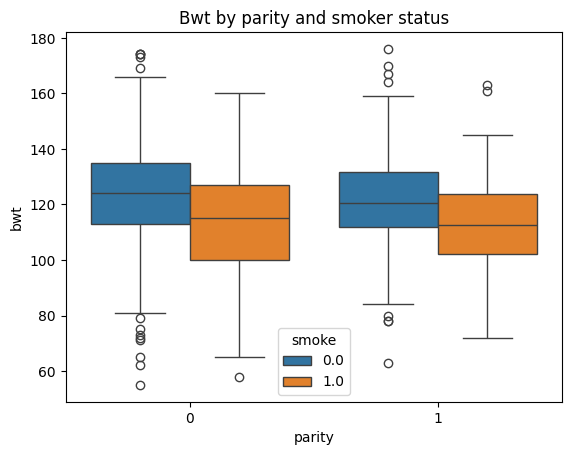

In [ ]:
sns.boxplot(
    x='parity',
    y='bwt',
    hue='smoke',
    data=data
)
plt.title("Bwt by parity and smoker status")
plt.show()

Vizualna procjena razlika i varijabilnosti.Razlike između sredine nisu velike, no određene razlike postoje.

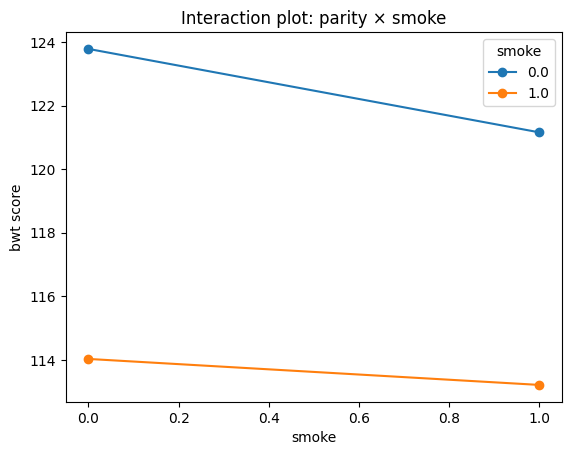

In [12]:
means = data.groupby(
    ['parity', 'smoke']
)['bwt'].mean().unstack()

means.plot(marker='o')
plt.xlabel("smoke")
plt.ylabel("bwt score")
plt.title("Interaction plot: parity × smoke")
plt.show()

Graf koji prikazuje srednje vrijednosti bwt po razinama faktora smoker i parity.Linije na grafu su približno paralelno, zbog čega možemo sugerirati da interakcija(utjecaj jednog faktora na zavisnu varijablu ovisi o razini drugog faktora) ne postoji!

In [13]:
model = smf.ols(
    "Q('bwt') ~ C(parity) * C(smoke)",
    data=data
).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Q('bwt')   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     26.44
Date:                Sun, 18 Jan 2026   Prob (F-statistic):           1.50e-16
Time:                        17:16:40   Log-Likelihood:                -5041.4
No. Observations:                1174   AIC:                         1.009e+04
Df Residuals:                    1170   BIC:                         1.011e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Definiran je two-way ANOVA model s interakcijom, odnosno dvofaktorska analiza varijance, kako bi se ispitao utjecaj dviju kategorijskih varijabli (parity i status pušača) na numeričku zavisnu varijablu – bwt. Model ispituje postoji li glavni efekt paritya, glavni efekt statusa pušača te njihov interakcijski učinak na bwt. Rezultati two-way ANOVA analize pokazali su da ne postoji statistički značajan glavni efekt paritya (p > 0.05) no postoji statusa pušača (p < 0.05) na bwt.Također, interakcija između paritya i statusa pušača nije statistički značajna (p = 0.455), što upućuje na to da učinak statusa pušača na bwt  ne ovisi o parityu.

Prije provođenja Two-Way ANOVA analize postavlja se linearni model kako bi se procijenili očekivani (predviđeni) iznosi zavisne varijable za svaku kombinaciju faktora. Na temelju tog modela izračunavaju se reziduali, odnosno razlike između stvarnih vrijednosti i vrijednosti koje model predviđa (grupni prosjeci). Analizom reziduala provjeravaju se pretpostavke normalnosti i homogenosti varijanci. Nakon što su pretpostavke zadovoljene, provodi se ANOVA kako bi se testirao statistički značaj glavnih efekata i njihove interakcije.

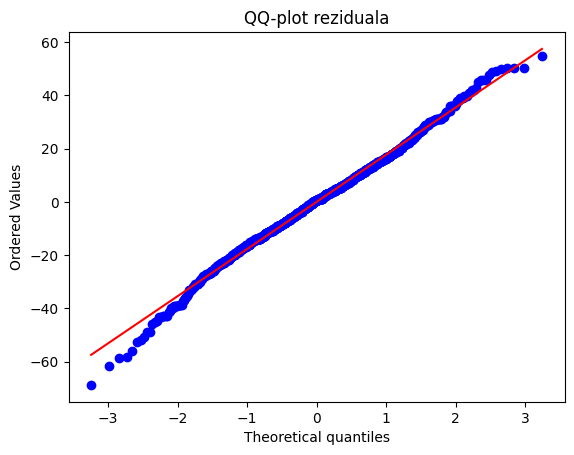

In [14]:
stats.probplot(model.resid, plot=plt)
plt.title("QQ-plot reziduala")
plt.show()

Reziduali, definirani kao razlika između stvarnih vrijednosti težine novorođenčadi i vrijednosti koje model predviđa (grupni prosjeci), približno su normalno distribuirani, čime je pretpostavka normalnosti za Two-Way ANOVA zadovoljena.Ako pretpostavke nisu zadovoljene, razmatraju se: transformacije podataka, robusne metode (npr. Welch-ANOVA).ANOVA uspoređuje prosjeke, a reziduali mjere koliko pojedinac odstupa od svog grupnog prosjeka.Ovo su reziduali svih opažanja, gdje je svako opažanje uspoređeno s prosjekom svoje pripadajuće grupe.


In [16]:
groups = data.groupby(['parity', 'smoke'])['bwt'].apply(list)

levene(*groups)

LeveneResult(statistic=np.float64(1.9596394094050271), pvalue=np.float64(0.11827867556034238))

Testirana je jednakost varijanci između grupa pomoću Levene testa. Homogenost varijanci predstavlja jednu od pretpostavki ANOVA-e. Budući da razlike u varijancama između grupa nisu statistički značajne (p = 0.11), pretpostavka homogenosti varijanci je zadovoljena.

In [17]:
anova_results = anova_lm(model, typ=2)
print(anova_results)

                           sum_sq      df          F        PR(>F)
C(parity)              843.983689     1.0   2.675785  1.021540e-01
C(smoke)             24086.332491     1.0  76.363865  8.037518e-18
C(parity):C(smoke)     175.884394     1.0   0.557628  4.553676e-01
Residual            369035.919007  1170.0        NaN           NaN


Status pušača ima veliki statistički značajan efekt na bwt(p<0.05).Parity nema značajan efekt(p>0.05).Interakcija spola i statusa pušača nije statistički značajna(p>0.05).
F pokazuje koliko su razlike između grupa velike u odnosu na varijabilnost unutar grupa.
F ≈ 2.65 (parity) → mali F mala razlika između grupa.
F ≈ 76.4 (smoke) → veliki F velika razlika između grupa.
F ≈ 0.55 (parityxsmoke) → mali F mala interakcija.